**用于估计幅度调制噪声包络的 DEMON 谱的 Python 实现。提供两个版本：平方律 DEMON 与希尔伯特变换 DEMON。根据具体应用场景，任一算法都可能更合适。两者都期望输入原始数据的数组以及滤波参数，并返回一个包含对输入数据包络估计值的输出数组。**


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as sg

In [20]:
def demon_classic_square(waveform, sample_rate, band_hz, lp_env_hz, env_sr, iir_order):
    """
    DEMON（平方律整流）：带通 → 平方 → 包络低通 → 降采样 → FFT 得 DEMON 频谱。

    参数设计：
    - band_hz   : 载频带（Hz），如 (1000,3000)。在较高载频带取包络能提升 SNR。
    - lp_env_hz : 包络低通截止（Hz），常用 150–250；200Hz 可覆盖桨频及若干谐波。
    - env_sr    : 包络降采样率（Hz），1000 足够覆盖 0–200Hz 且省算力。
    - iir_order : 巴特沃斯阶数，4 阶 + filtfilt（零相位）较稳健。

    Returns:
        {
          'env'     : 降采样后的包络时序（np.ndarray [T_env]）
          'env_sr'  : 包络采样率（np.ndarray [1]，int）
          'freqs'   : DEMON 频率轴（Hz，np.ndarray [F]）
          'spectrum': DEMON 幅度谱（线性幅度，np.ndarray [F]）
        }
    """
    nyq = 0.5 * sample_rate
    low = max(1e-6, band_hz[0] / nyq)
    high = min(0.999, band_hz[1] / nyq)
    b_bp, a_bp = sg.butter(iir_order, [low, high], btype="bandpass")
    x_bp = sg.filtfilt(b_bp, a_bp, waveform)

    env = np.square(x_bp)
    env -= env.mean()

    cut = min(0.999, lp_env_hz / nyq)
    b_lp, a_lp = sg.butter(iir_order, cut, btype="lowpass")
    env = sg.filtfilt(b_lp, a_lp, env)

    if env_sr < sample_rate:
        env = sg.resample_poly(env, env_sr, sample_rate)
        env_sr_out = env_sr
    else:
        env_sr_out = sample_rate

    N = int(2 ** np.ceil(np.log2(len(env) + 1e-9)))
    win = sg.windows.hann(len(env), sym=False)
    spec = np.fft.rfft(env * win, n=N)
    freqs = np.fft.rfftfreq(N, 1.0 / env_sr_out)

    return {
        "env": env,
        "env_sr": np.array([env_sr_out], dtype=np.int64),
        "freqs": freqs,
        "spectrum": np.abs(spec),
    }

In [21]:
def demon_classic_hilbert(waveform, sample_rate, band_hz, lp_env_hz, env_sr, iir_order):
    """
    DEMON（Hilbert 包络）：带通 → Hilbert 解析包络 → 包络低通 → 降采样 → FFT。

    与平方律路线相比，Hilbert 包络对弱载频时更平滑，但二者在 DEMON 频域上常相近。
    """
    nyq = 0.5 * sample_rate
    low = max(1e-6, band_hz[0] / nyq)
    high = min(0.999, band_hz[1] / nyq)
    b_bp, a_bp = sg.butter(iir_order, [low, high], btype="bandpass")
    x_bp = sg.filtfilt(b_bp, a_bp, waveform)

    env = np.abs(sg.hilbert(x_bp))
    env -= env.mean()

    cut = min(0.999, lp_env_hz / nyq)
    b_lp, a_lp = sg.butter(iir_order, cut, btype="lowpass")
    env = sg.filtfilt(b_lp, a_lp, env)

    if env_sr < sample_rate:
        env = sg.resample_poly(env, env_sr, sample_rate)
        env_sr_out = env_sr
    else:
        env_sr_out = sample_rate

    N = int(2 ** np.ceil(np.log2(len(env) + 1e-9)))
    win = sg.windows.hann(len(env), sym=False)
    spec = np.fft.rfft(env * win, n=N)
    freqs = np.fft.rfftfreq(N, 1.0 / env_sr_out)

    return {
        "env": env,
        "env_sr": np.array([env_sr_out], dtype=np.int64),
        "freqs": freqs,
        "spectrum": np.abs(spec),
    }

In [22]:
def plot_demon_spectrum(spectrum, freqs, xlim_hz, title, save_path):
    """1D DEMON 频谱曲线（纵轴 dB，横轴 0~xlim_hz）。"""
    plt.figure(figsize=(12, 8))
    plt.plot(freqs, 20.0 * np.log10(np.maximum(1e-12, np.abs(spectrum))))
    plt.xlim(0, xlim_hz)
    plt.xlabel("DEMON frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title(title)
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

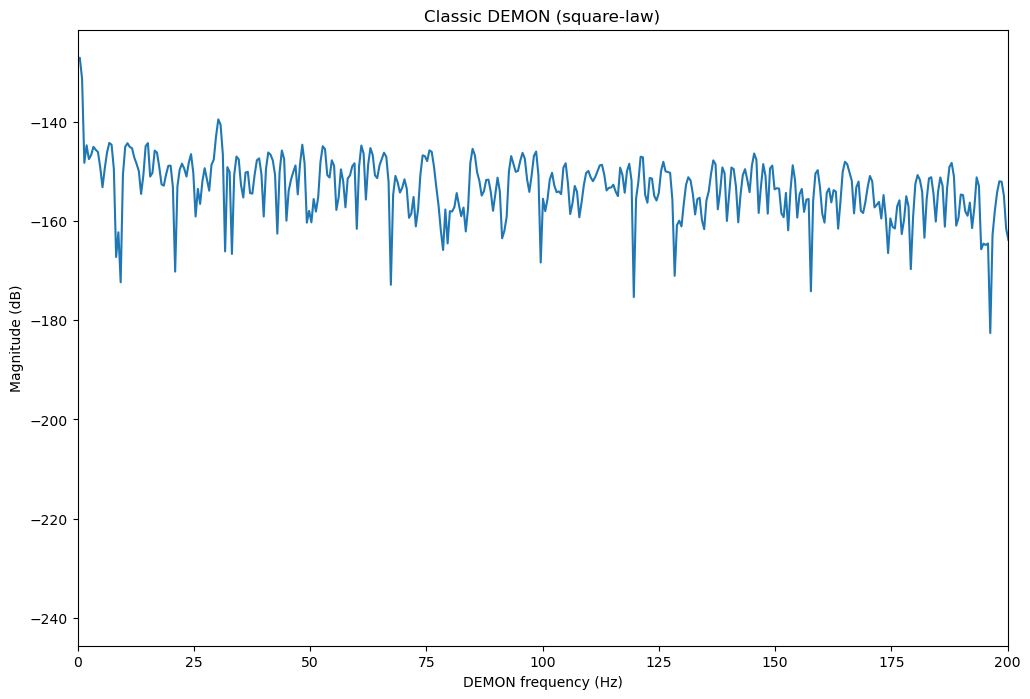

In [29]:
audio_file = r"E:\数据集\ShipEar\data_preprocessing\4_Frame_Windows_2s_50%\6__10_07_13_marDeCangas_Entra_18.wav"
waveform, sample_rate = librosa.load(audio_file, sr=None)
demon_square_features = demon_classic_square(waveform, sample_rate, band_hz=(1000.0, 3000.0), lp_env_hz=200.0, env_sr=1000, iir_order=4)
plot_demon_spectrum(demon_square_features["spectrum"], demon_square_features["freqs"], xlim_hz=200, title="Classic DEMON (square-law)", save_path=None)

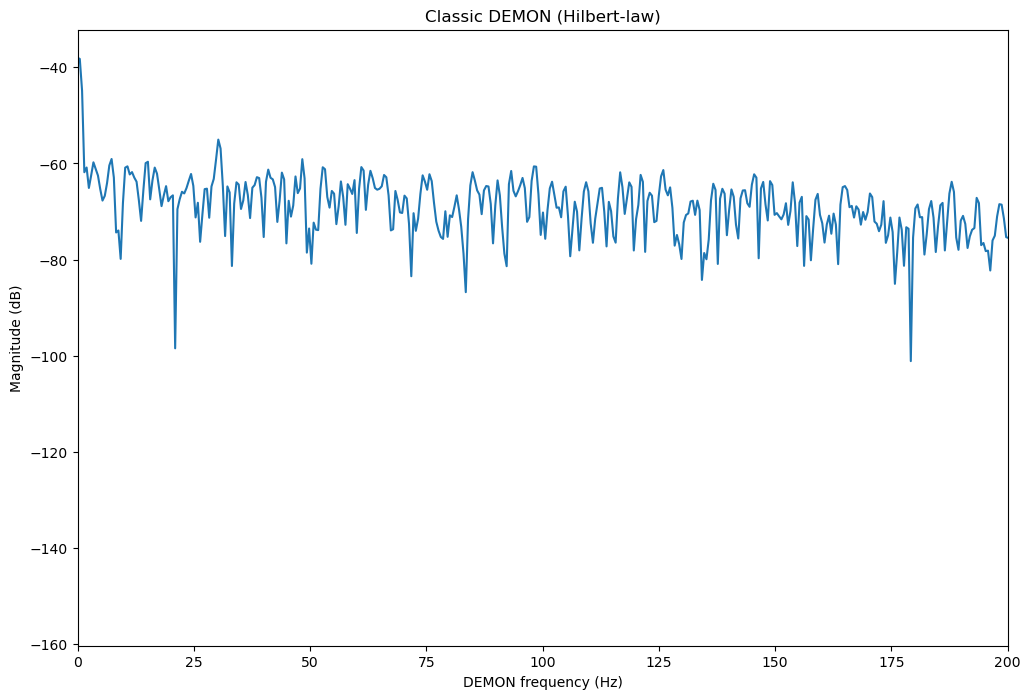

In [30]:
demon_hilbert_features = demon_classic_hilbert(waveform, sample_rate, band_hz=(1000.0, 3000.0), lp_env_hz=200.0, env_sr=1000, iir_order=4)
plot_demon_spectrum(demon_hilbert_features["spectrum"], demon_hilbert_features["freqs"], xlim_hz=200, title="Classic DEMON (Hilbert-law)", save_path=None)